# Local ToE

- In this version I have added in the other tests (KS, Anerson Darling)

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import dask.array
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from scipy.stats import ttest_ind


from numpy.typing import ArrayLike
from typing import Callable

# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

Matplotlib created a temporary config/cache directory at /jobfs/111963638.gadi-pbs/matplotlib-ixnf1jnt because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import time_of_emrgence_calc as toe

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client.cluster.scale(28)
client

- State start
- Found stale lock file and directory '/jobfs/111963638.gadi-pbs/dask-scratch-space/scheduler-k8mk1jo7', purging
-   Scheduler at:     tcp://127.0.0.1:41705
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:35663'
-         Start Nanny at: 'tcp://127.0.0.1:40061'
-         Start Nanny at: 'tcp://127.0.0.1:46383'
-         Start Nanny at: 'tcp://127.0.0.1:34827'
-         Start Nanny at: 'tcp://127.0.0.1:41687'
-         Start Nanny at: 'tcp://127.0.0.1:40443'
-         Start Nanny at: 'tcp://127.0.0.1:37965'
-         Start Nanny at: 'tcp://127.0.0.1:39693'
-         Start Nanny at: 'tcp://127.0.0.1:43595'
-         Start Nanny at: 'tcp://127.0.0.1:40501'
-         Start Nanny at: 'tcp://127.0.0.1:35571'
-         Start Nanny at: 'tcp://127.0.0.1:41787'
-         Start Nanny at: 'tcp://127.0.0.1:36529'
-         Start Nanny at: 'tcp://127.0.0.1:35029'
-         Start Nanny at: 'tcp://127.0.0.1:35613

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41705,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:41033,Total threads: 1
Dashboard: /proxy/46637/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:35663,


In [4]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

# Opening Best

In [5]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [6]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})
best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()

0.3.0


In [7]:
# Only 43MB - load into memory
# best_ds = best_ds.compute()

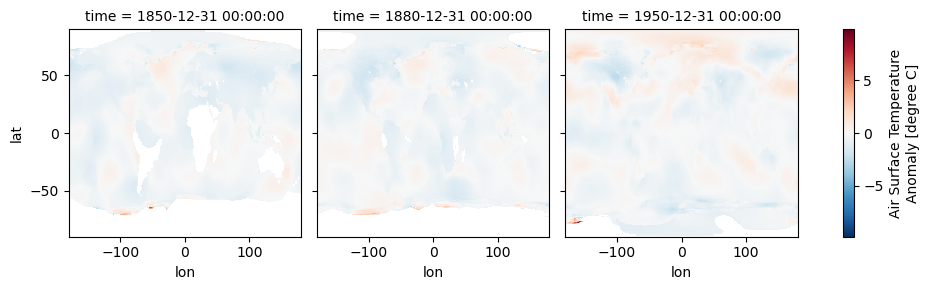

In [8]:
best_ds.isel(time=[0, 30, 100]).plot(col='time')

In [9]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
dask.array<chunksize=(50, 90, 120), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [10]:
base_period_ds_count = base_period_ds.count(dim='time')

In [11]:
data_availability_levels = np.arange(0, 61, 10)
data_availability_levels

array([ 0, 10, 20, 30, 40, 50, 60])

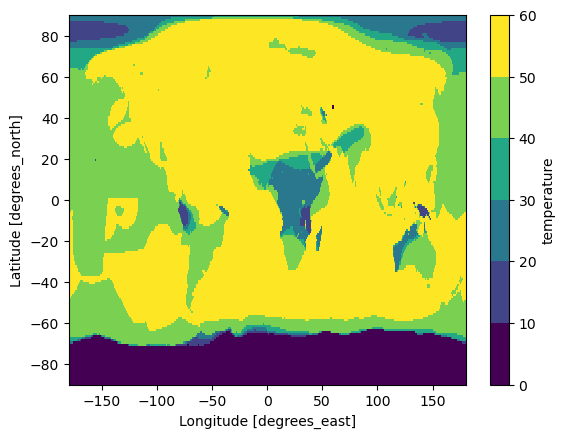

In [12]:
base_period_ds_count.plot(levels=data_availability_levels)

In [13]:
data_availability_mask = xr.where(base_period_ds_count>40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
dask.array<chunksize=(90, 120), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

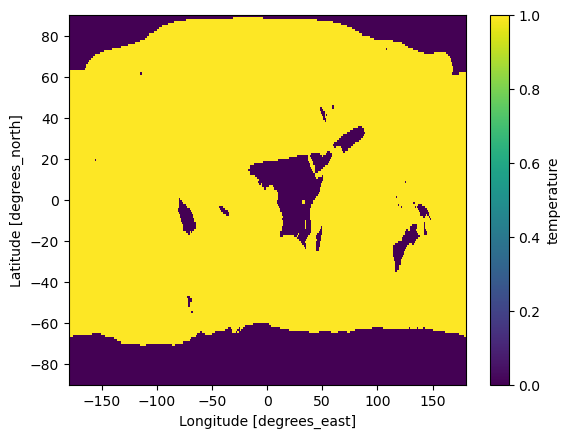

In [14]:
data_availability_mask.plot()

In [15]:
best_ds = best_ds.where(data_availability_mask)

In [16]:
base_period_ds = base_period_ds.where(data_availability_mask)

# Calculations

In [17]:
window = 20

In [18]:
def return_ttest_pvalue(test_arr, base_arr):
    """
    Compute T-Test p-value between two arrays.

    Parameters:
        test_arr (ArrayLike): Array to test against base_arr.
        base_arr (ArrayLike): Base array to compare against.

    Returns:
        float: T-Test p-value.
    """
    return ttest_ind(test_arr, base_arr).pvalue

In [19]:
def stats_test_1d_array(arr: ArrayLike, window: int, base_period_length:int=50) -> ArrayLike:
    """
    Apply Kolmogorov-Smirnov test along a 1D array.

    Parameters:
        arr (ArrayLike): 1D array to apply the test to.
        window (int): Size of the rolling window for the test.
        base_period_length (int, optional): Length of the base period. Defaults to 50.

    Returns:
        ArrayLike: Array of p-values.
    """
    #print(arr)
    # The data to use for the base period
    base_list = arr[:base_period_length]
    # Fill function with base data - this needs to be done each time as the base period is unique
    stats_test_partial = partial(return_ttest_pvalue, base_arr=base_list) #statstest
    # Stop when there are not enough points left
    
    number_iterations = arr.shape[0] - window
    kstest_array = np.zeros(number_iterations)
    for t in np.arange(number_iterations):
        arr_subset = arr[t:t+window]
        ks_value = stats_test_partial(arr_subset)#.pvalue
        kstest_array[t] = ks_value
    return kstest_array

In [20]:
subset_kwargs = dict(lat=slice(30,60), lon=slice(30,60))
# chunks = {'time':-1, 'lat':10}

In [21]:
best_ds_subset = best_ds.isel(**subset_kwargs)#.chunk(chunks)#.data

In [22]:
best_ds_subset

<xarray.DataArray 'temperature' (time: 175, lat: 30, lon: 30)>
dask.array<chunksize=(175, 30, 30), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 -59.5 -58.5 -57.5 -56.5 ... -33.5 -32.5 -31.5 -30.5
  * lon      (lon) float32 -149.5 -148.5 -147.5 -146.5 ... -122.5 -121.5 -120.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [23]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':1, 'lon':1, 'time':-1}

In [27]:
best_ds_subset_window = best_ds_subset.chunk(CHUNKS_FOR_PVALUE_TESTS).rolling(time=window).construct('window_dim').persist()#[(window-1):]

In [28]:
base_period_subset_ds = base_period_ds.chunk(CHUNKS_FOR_PVALUE_TESTS).isel(**subset_kwargs).rename({'time':'window_dim'}).persist()

In [30]:
output_da = xr.apply_ufunc(
        return_ttest_pvalue,
        best_ds_subset_window,
        base_period_subset_ds,
        input_core_dims=[['window_dim'], ['window_dim']],
        exclude_dims={'window_dim'},
        vectorize=True,
        dask='parallelized'#''
    ).compute()

In [31]:
# dask.visualize(output_da.data, rankdir="LR")

In [30]:
best_ds.lat.shape[0] * best_ds.lon.shape[0]

64800

In [33]:
# Time takes x scale up factor/ minuts in hour
 #14.8 - when using 16 workers, but no chunk change
# 17 -  when using default worked and 
time_taken = 6.51
time_taken* 72/60

7.811999999999999

In [32]:
64800/900

72.0

- Connection to tcp://127.0.0.1:46198 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:41553', name: 24, status: running, memory: 1, processing: 0> (stimulus_id='handle-worker-cleanup-1710741774.7383204')
- Connection to tcp://127.0.0.1:46444 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:35933', name: 14, status: running, memory: 1, processing: 0> (stimulus_id='handle-worker-cleanup-1710741774.7521448')
- Connection to tcp://127.0.0.1:46324 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:42377', name: 21, status: running, memory: 39, processing: 0> (stimulus_id='handle-worker-cleanup-1710741774.7551737')
- Connection to tcp://127.0.0.1:46358 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:38863', name: 7, status: running, memory: 1, processing: 0> (stimulus_id='handle-worker-cleanup-1710741774.760002')
- Connection to tcp://127.0.0.1:46390 has been closed.
- Remove worker <WorkerState 'tcp://127.0.0.1:46121', name: 26, status

2024-03-18 17:02:54,956 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/utils_comm.py", line 434, in retry


- Closing Nanny at 'tcp://127.0.0.1:34809'. Reason: nanny-close-gracefully
- Closing Nanny at 'tcp://127.0.0.1:41171'. Reason: nanny-close-gracefully
- Worker process 1602107 was killed by signal 15
- Worker process 1602052 was killed by signal 15
- Worker process 1602087 was killed by signal 15
- Worker process 1602092 was killed by signal 15
- Worker process 1602072 was killed by signal 15
- Worker process 1602115 was killed by signal 15
- Worker process 1602081 was killed by signal 15
- Worker process 1602066 was killed by signal 15
- Closing Nanny at 'tcp://127.0.0.1:39499'. Reason: nanny-close-gracefully
- Worker process 1602112 was killed by signal 15
- Worker process 1602102 was killed by signal 15
- Worker process 1602085 was killed by signal 15
- Worker process 1602099 was killed by signal 15
- Closing Nanny at 'tcp://127.0.0.1:45903'. Reason: nanny-close-gracefully
- Worker process 1602076 was killed by signal 15
- Closing Nanny at 'tcp://127.0.0.1:36933'. Reason: nanny-close

In [23]:
# stats_test_1d_array_partial = partial(
#     stats_test_1d_array, 
#     window=20,
#     base_period_length=50
# )

In [24]:
# %%time
# out_array = np.apply_along_axis(
#     stats_test_1d_array_partial,
#     best_ds.get_axis_num('time'),
#     best_ds_subset.values # fails with data
# )

In [25]:
# out_array.shape

In [26]:
# dask.array.apply_along_axis

In [27]:
# %%time
# out_array = dask.array.apply_along_axis(
#     stats_test_1d_array_partial,
#     best_ds.get_axis_num('time'),
#     best_ds.isel(**subset_kwargs).chunk(chunks).values
# )

In [29]:
# best_ds_subset_compute = best_ds_subset.compute()

In [30]:
# base_period_ds_compute = base_period_ds.isel(**subset_kwargs).compute()

In [31]:
# %%time
# xr.apply_ufunc(
#         return_ttest_pvalue,
#         best_ds_subset_compute.rolling(time=window).construct('window_dim')[(window-1):],
#         base_period_ds_compute.rename({'time':'window_dim'}),
#         input_core_dims=[['window_dim'], ['window_dim']],
#         exclude_dims={'window_dim'},
#         vectorize=True,
#         dask='parallelized'#''
#     )

In [32]:
# %%time
# xr.apply_ufunc(
#         return_ttest_pvalue,
#         best_ds_subset.rolling(time=window).construct('window_dim')[(window-1):],
#         base_period_ds.isel(**subset_kwargs).rename({'time':'window_dim'}),
#         input_core_dims=[['window_dim'], ['window_dim']],
#         exclude_dims={'window_dim'},
#         vectorize=True,
#         dask='parallelized'#''
#     ).compute()